In [1]:
import sys

sys.path.append("../")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import data.drawings.make_tasks as drawing_tasks
from src.analysis_utilities import SynthesisExperimentAnalyzer
from src.config_builder import ExperimentType

/opt/conda/envs/laps/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
sns.set_theme(style="whitegrid", font_scale=1.25, rc={'figure.figsize':(12, 8)})

In [5]:
%config InlineBackend.figure_format = 'retina'

In [6]:
EXPERIMENT_NAME = "runs_re2"
DOMAIN = "re2"

# EXPERIMENT_NAME = "runs_clevr"
# DOMAIN = "clevr"

COMPUTE_LIKELIHOODS = True

FIGURES_DIR = os.path.join("figures", EXPERIMENT_NAME)
FIGURES_DOMAIN_DIR = os.path.join("figures", EXPERIMENT_NAME, DOMAIN)
os.makedirs(FIGURES_DOMAIN_DIR, exist_ok=True)

In [7]:
analyzer = SynthesisExperimentAnalyzer(
    experiment_name=EXPERIMENT_NAME,
    allow_incomplete_results=True,
    compute_likelihoods=COMPUTE_LIKELIHOODS,
    batch_size = 96,
    seeds = [111, 222, 333],
)

Experiment directory: ../experiments_iterative/outputs/runs_re2
Available domains: ['re2']


# Analysis 1: Tasks solved over time

### Tasks solved vs. LAPS iteration

In [8]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df

,request,task,programs,best_search_time,split,seed,iteration,experiment_type
0,"{'constructor': '->', 'arguments': [{'construc...",re2_train_0_if_the_word_ends_with_any_letter_a...,[],NaN,train,111,0,baseline_dreamcoder
1,"{'constructor': '->', 'arguments': [{'construc...",re2_train_1_if_there_is_consonant_replace_that...,[],NaN,train,111,0,baseline_dreamcoder
2,"{'constructor': '->', 'arguments': [{'construc...",re2_train_2_if_the_word_ends_with_consonant_s_...,[],NaN,train,111,0,baseline_dreamcoder
3,"{'constructor': '->', 'arguments': [{'construc...",re2_train_3_if_there_is_d_replace_that_with_y,[],NaN,train,111,0,baseline_dreamcoder
4,"{'constructor': '->', 'arguments': [{'construc...",re2_train_4_if_there_is_b_add_k_before_that,[],NaN,train,111,0,baseline_dreamcoder
...,...,...,...,...,...,...,...,...
34545,"{'constructor': '->', 'arguments': [{'construc...",re2_test_495_if_there_is_vowel_n_replace_that_...,[],NaN,test,222,9,gpt_generation
34546,"{'constructor': '->', 'arguments': [{'construc...",re2_test_496_if_the_word_ends_with_any_letter_...,[{'program': '(lambda (#(lambda (lambda (_rfla...,17.626202,test,222,9,gpt_generation
34547,"{'constructor': '->', 'arguments': [{'construc...",re2_test_497_if_the_word_starts_with_any_lette...,[{'program': '(lambda (#(lambda (lambda (lambd...,60.615848,test,222,9,gpt_generation
34548,"{'constructor': '->', 'arguments': [{'construc...",re2_test_498_if_there_is_vowel_r_add_u_before_...,[],NaN,test,222,9,gpt_generation


In [9]:
df_results = (
    df.groupby(["experiment_type", "seed", "iteration", "split"])
    .best_search_time.count()
    .reset_index(name="n_solved")
)

# Duplicate "benchmark_enumeration" for n_iterations
df_list = [df_results[df_results.experiment_type != "enumeration"]]
for iteration in sorted(df_results.iteration.unique()):
    df_tmp = df_results[df_results.experiment_type == "enumeration"].copy()
    df_tmp["iteration"] = iteration
    df_list.append(df_tmp)
df_results = pd.concat(df_list, axis=0).reset_index(drop=True)

df_results

,experiment_type,seed,iteration,split,n_solved
0,baseline_dreamcoder,111,0,test,67
1,baseline_dreamcoder,111,0,train,15
2,baseline_dreamcoder,111,1,train,31
3,baseline_dreamcoder,111,2,train,54
4,baseline_dreamcoder,111,3,test,130
...,...,...,...,...,...
65,gpt_generation,222,6,train,158
66,gpt_generation,222,7,train,159
67,gpt_generation,222,8,train,160
68,gpt_generation,222,9,test,197


Text(0.5, 1.0, 're2')

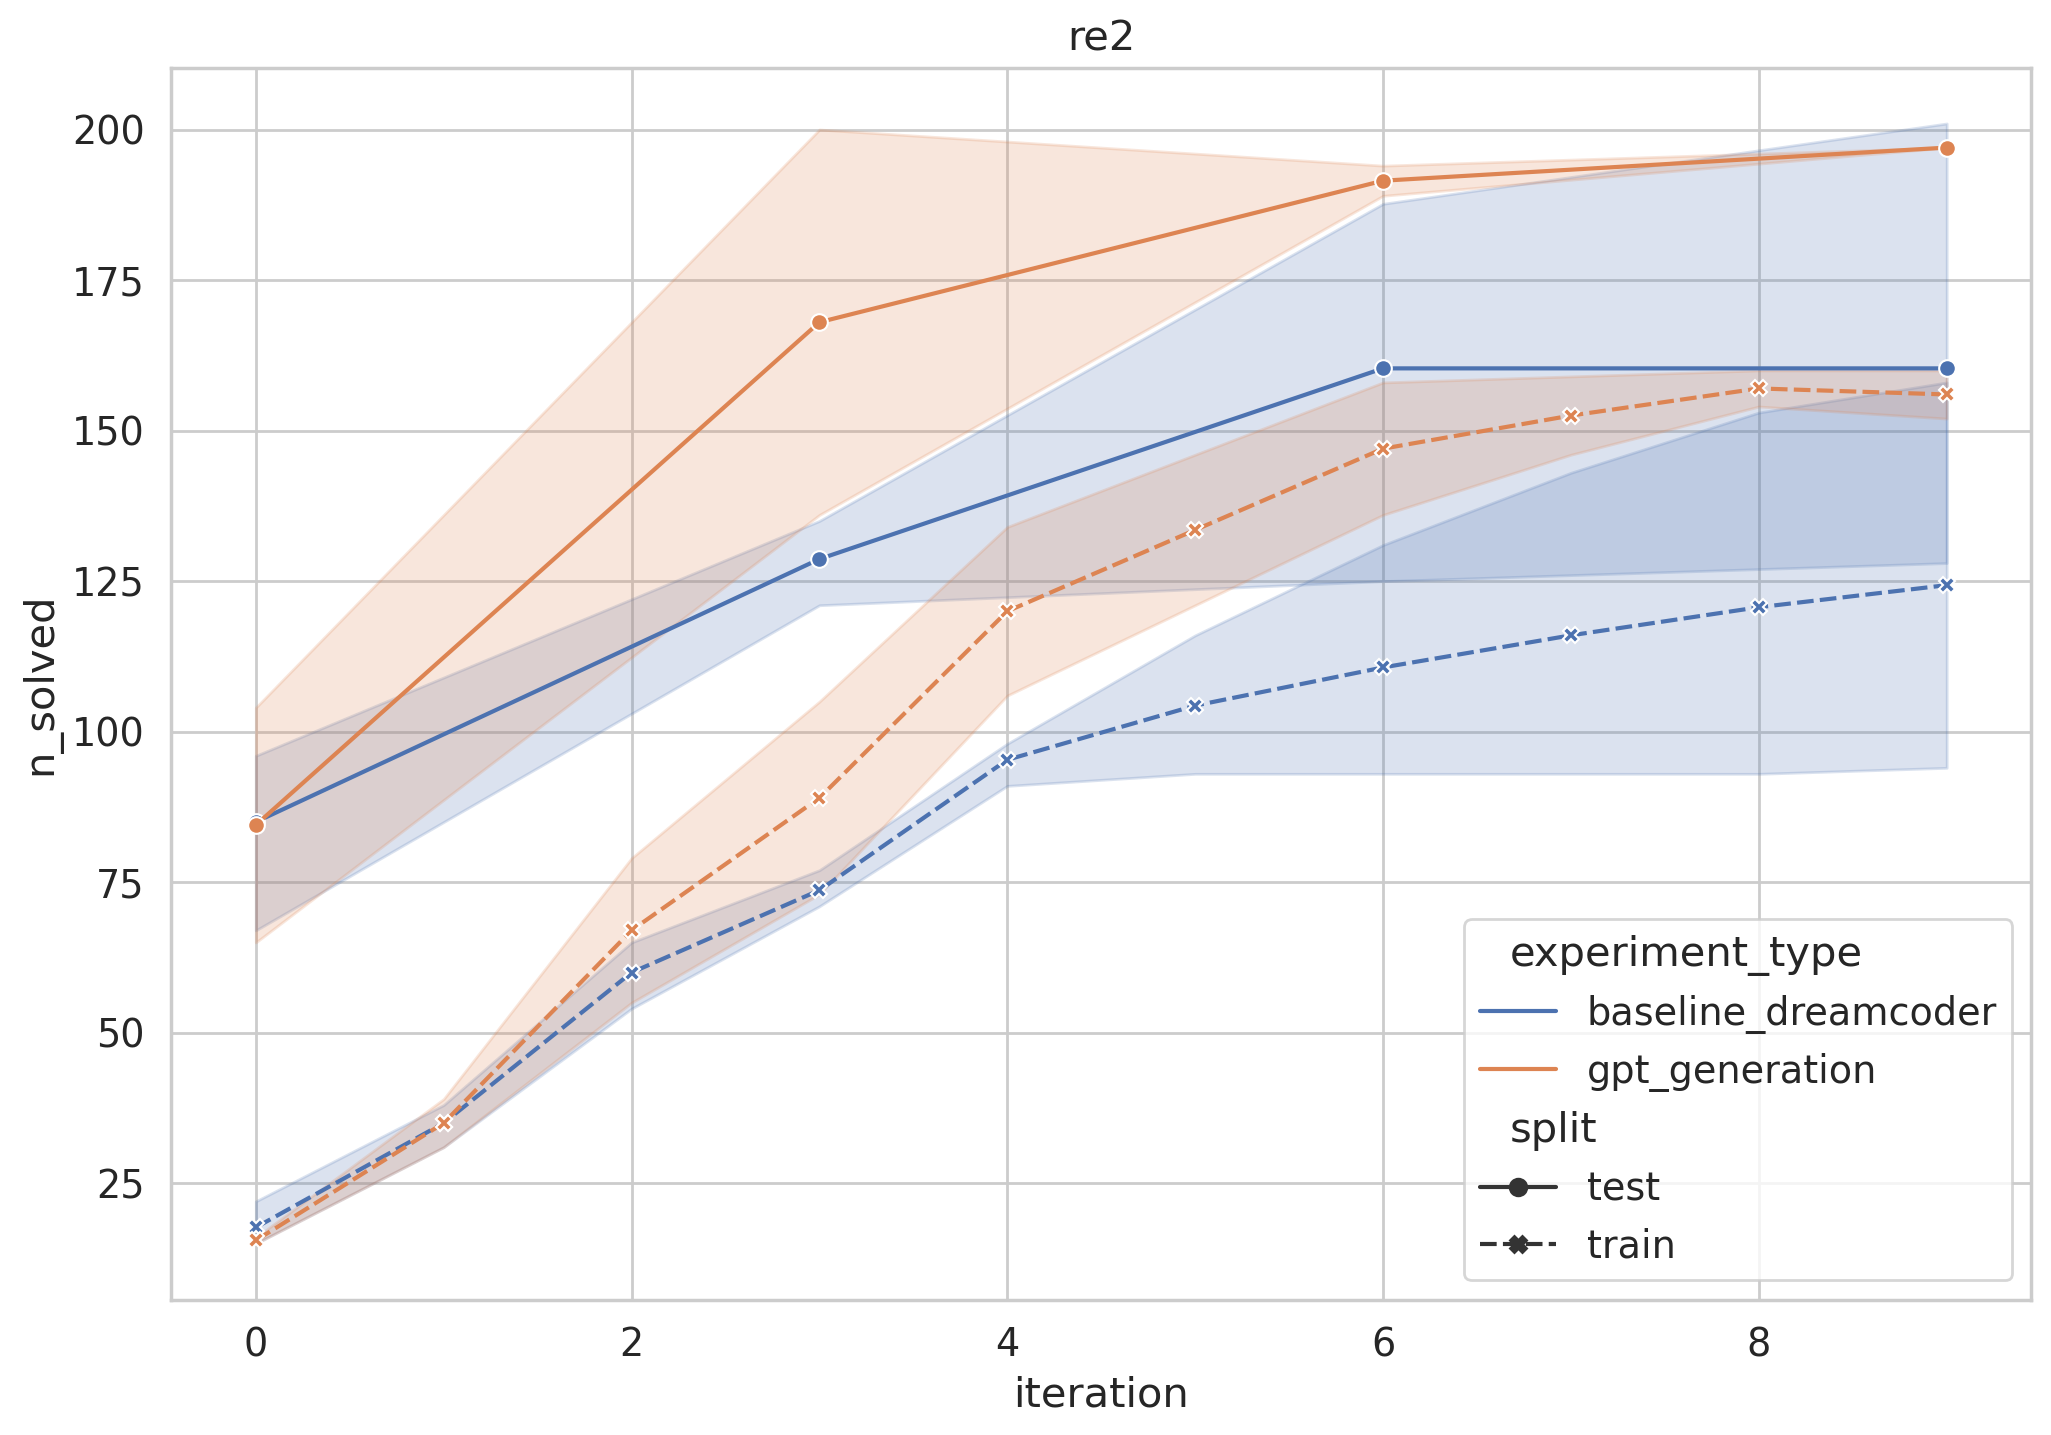

In [10]:
sns.lineplot(
    data=df_results, 
    x="iteration", 
    y="n_solved", 
    hue="experiment_type",
    style="split",
    markers=True,
)
plt.title(f"{DOMAIN}")

Text(0.5, 1.0, 're2')

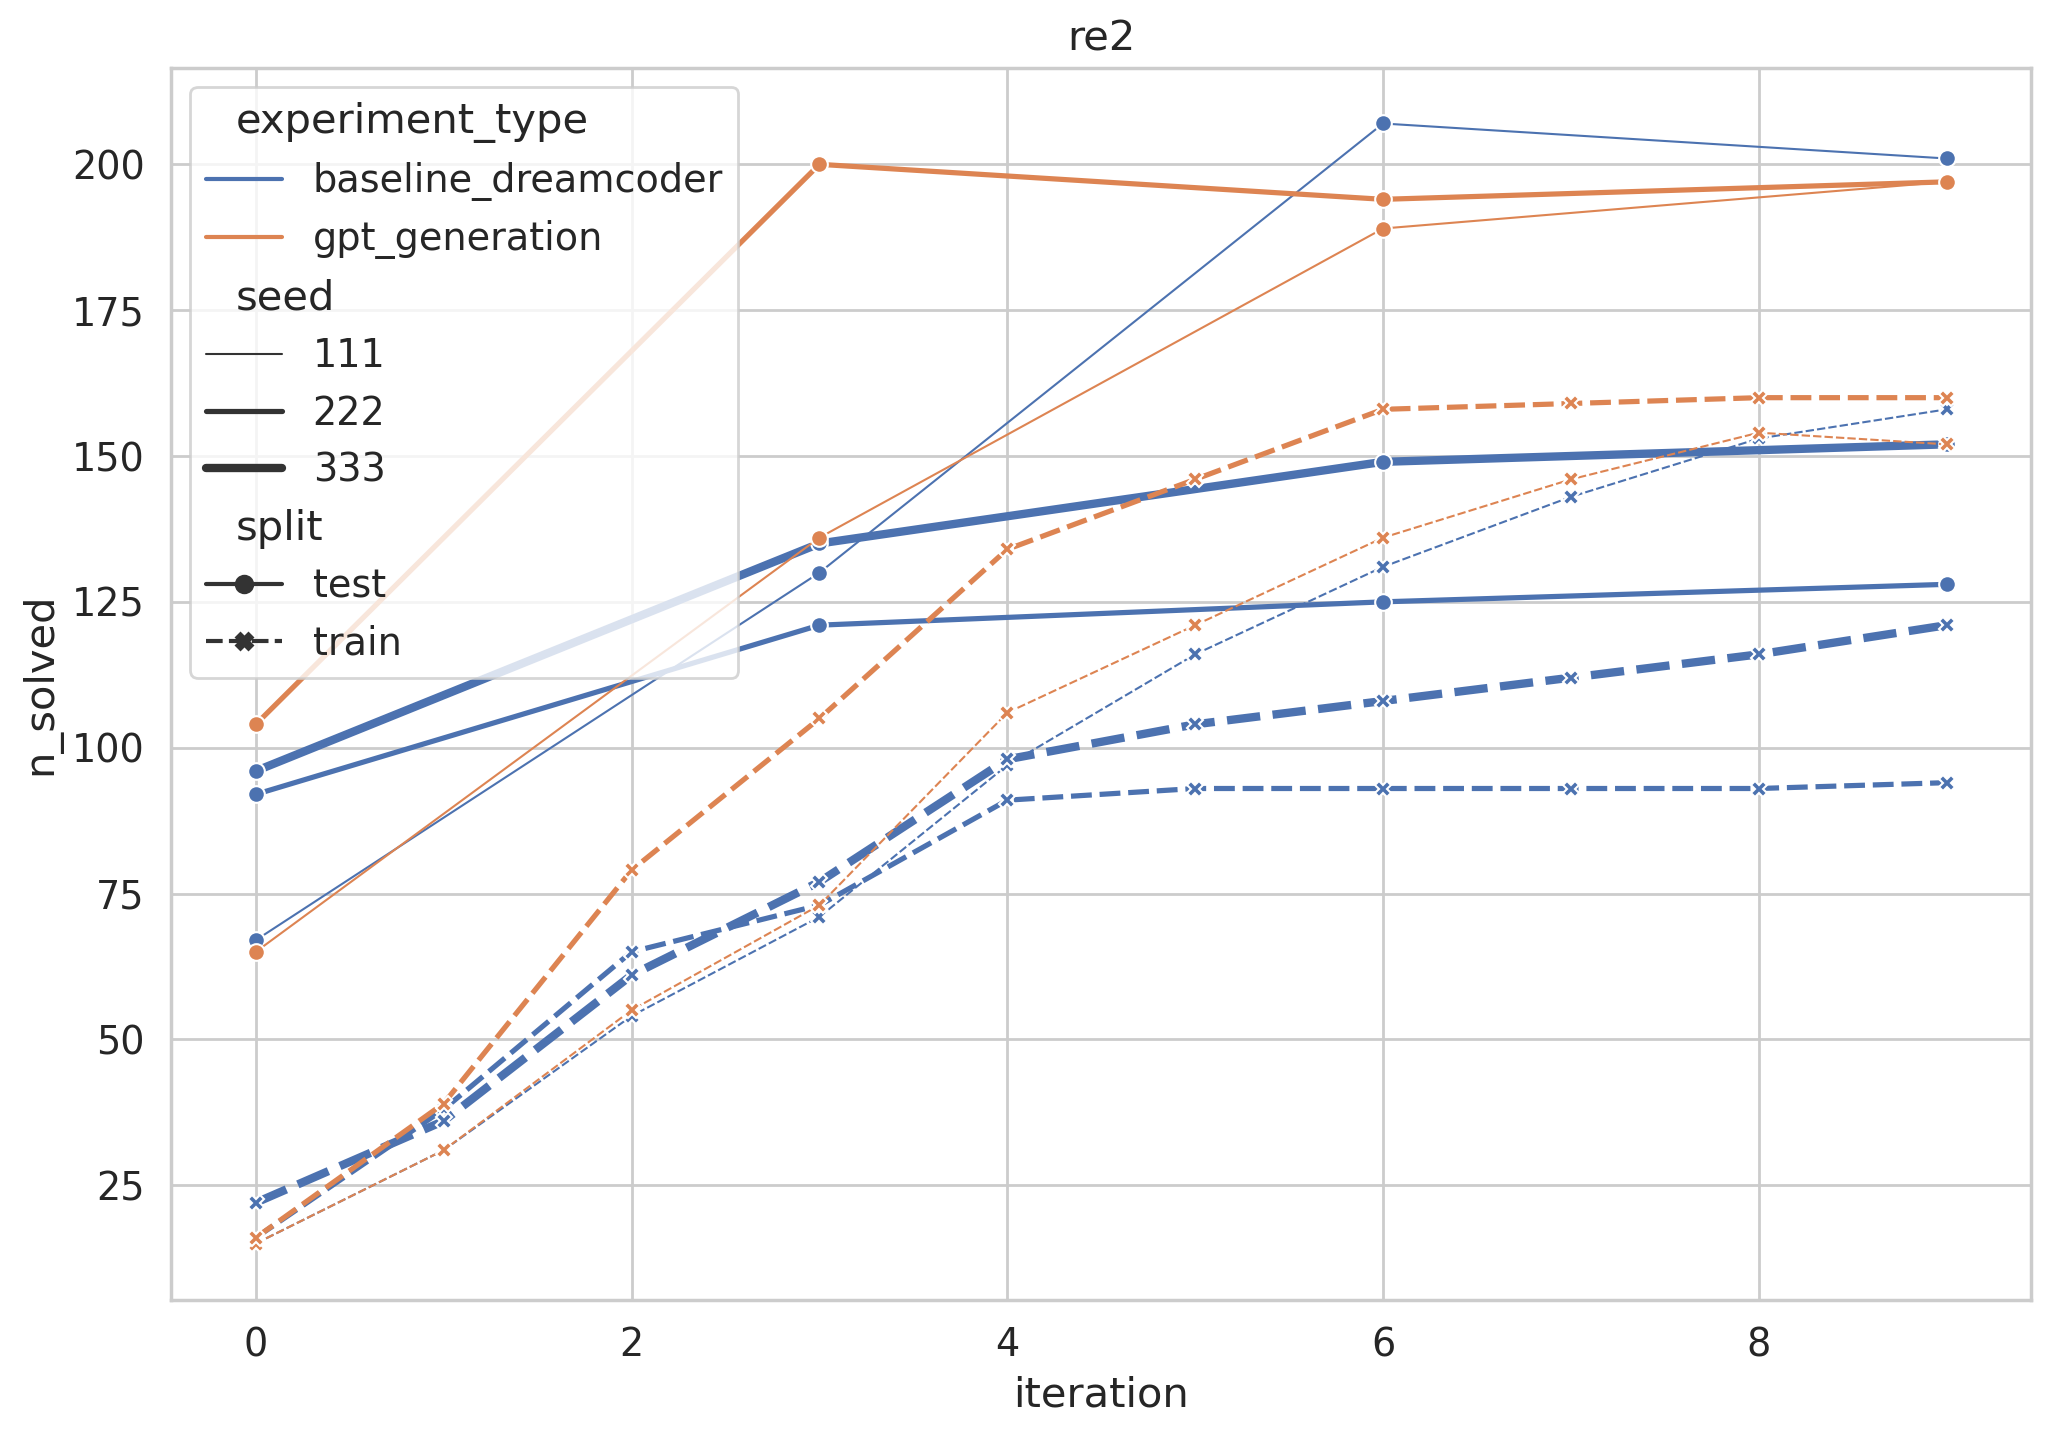

In [11]:
sns.lineplot(
    data=df_results, 
    x="iteration", 
    y="n_solved", 
    hue="experiment_type",
    style="split",
    size="seed",
    markers=True,
)
plt.title(f"{DOMAIN}")

Text(0.5, 1.0, 're2')

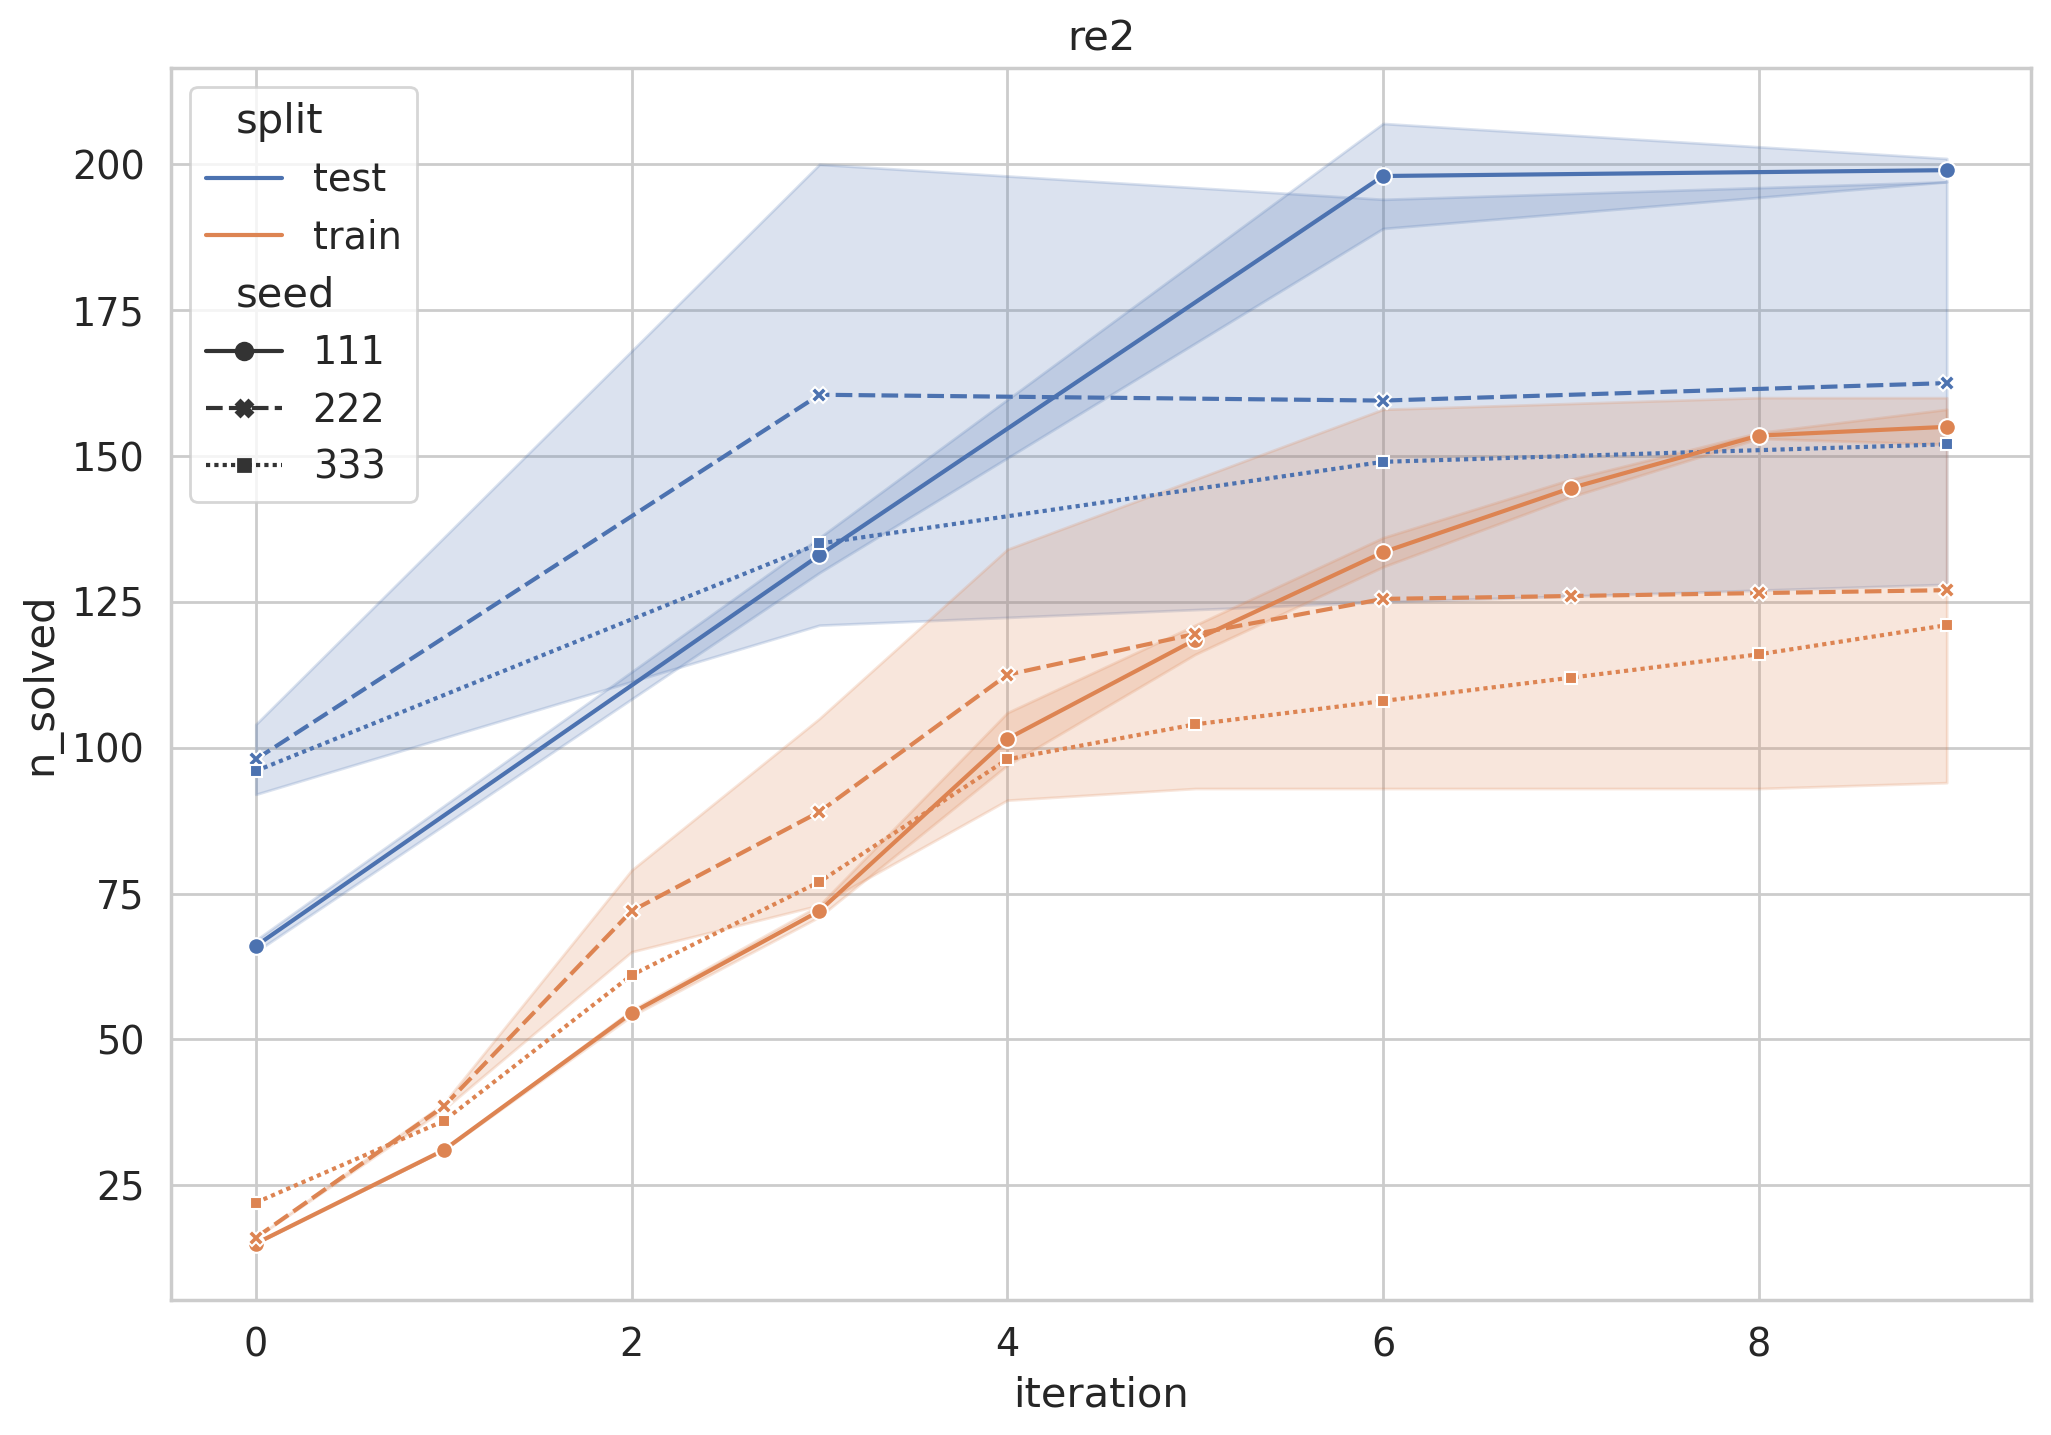

In [12]:
sns.lineplot(
    data=df_results, 
    x="iteration", 
    y="n_solved", 
    hue="split",
    style="seed", 
    markers=True,
)
plt.title(f"{DOMAIN}")

Text(0.5, 1.0, 're2')

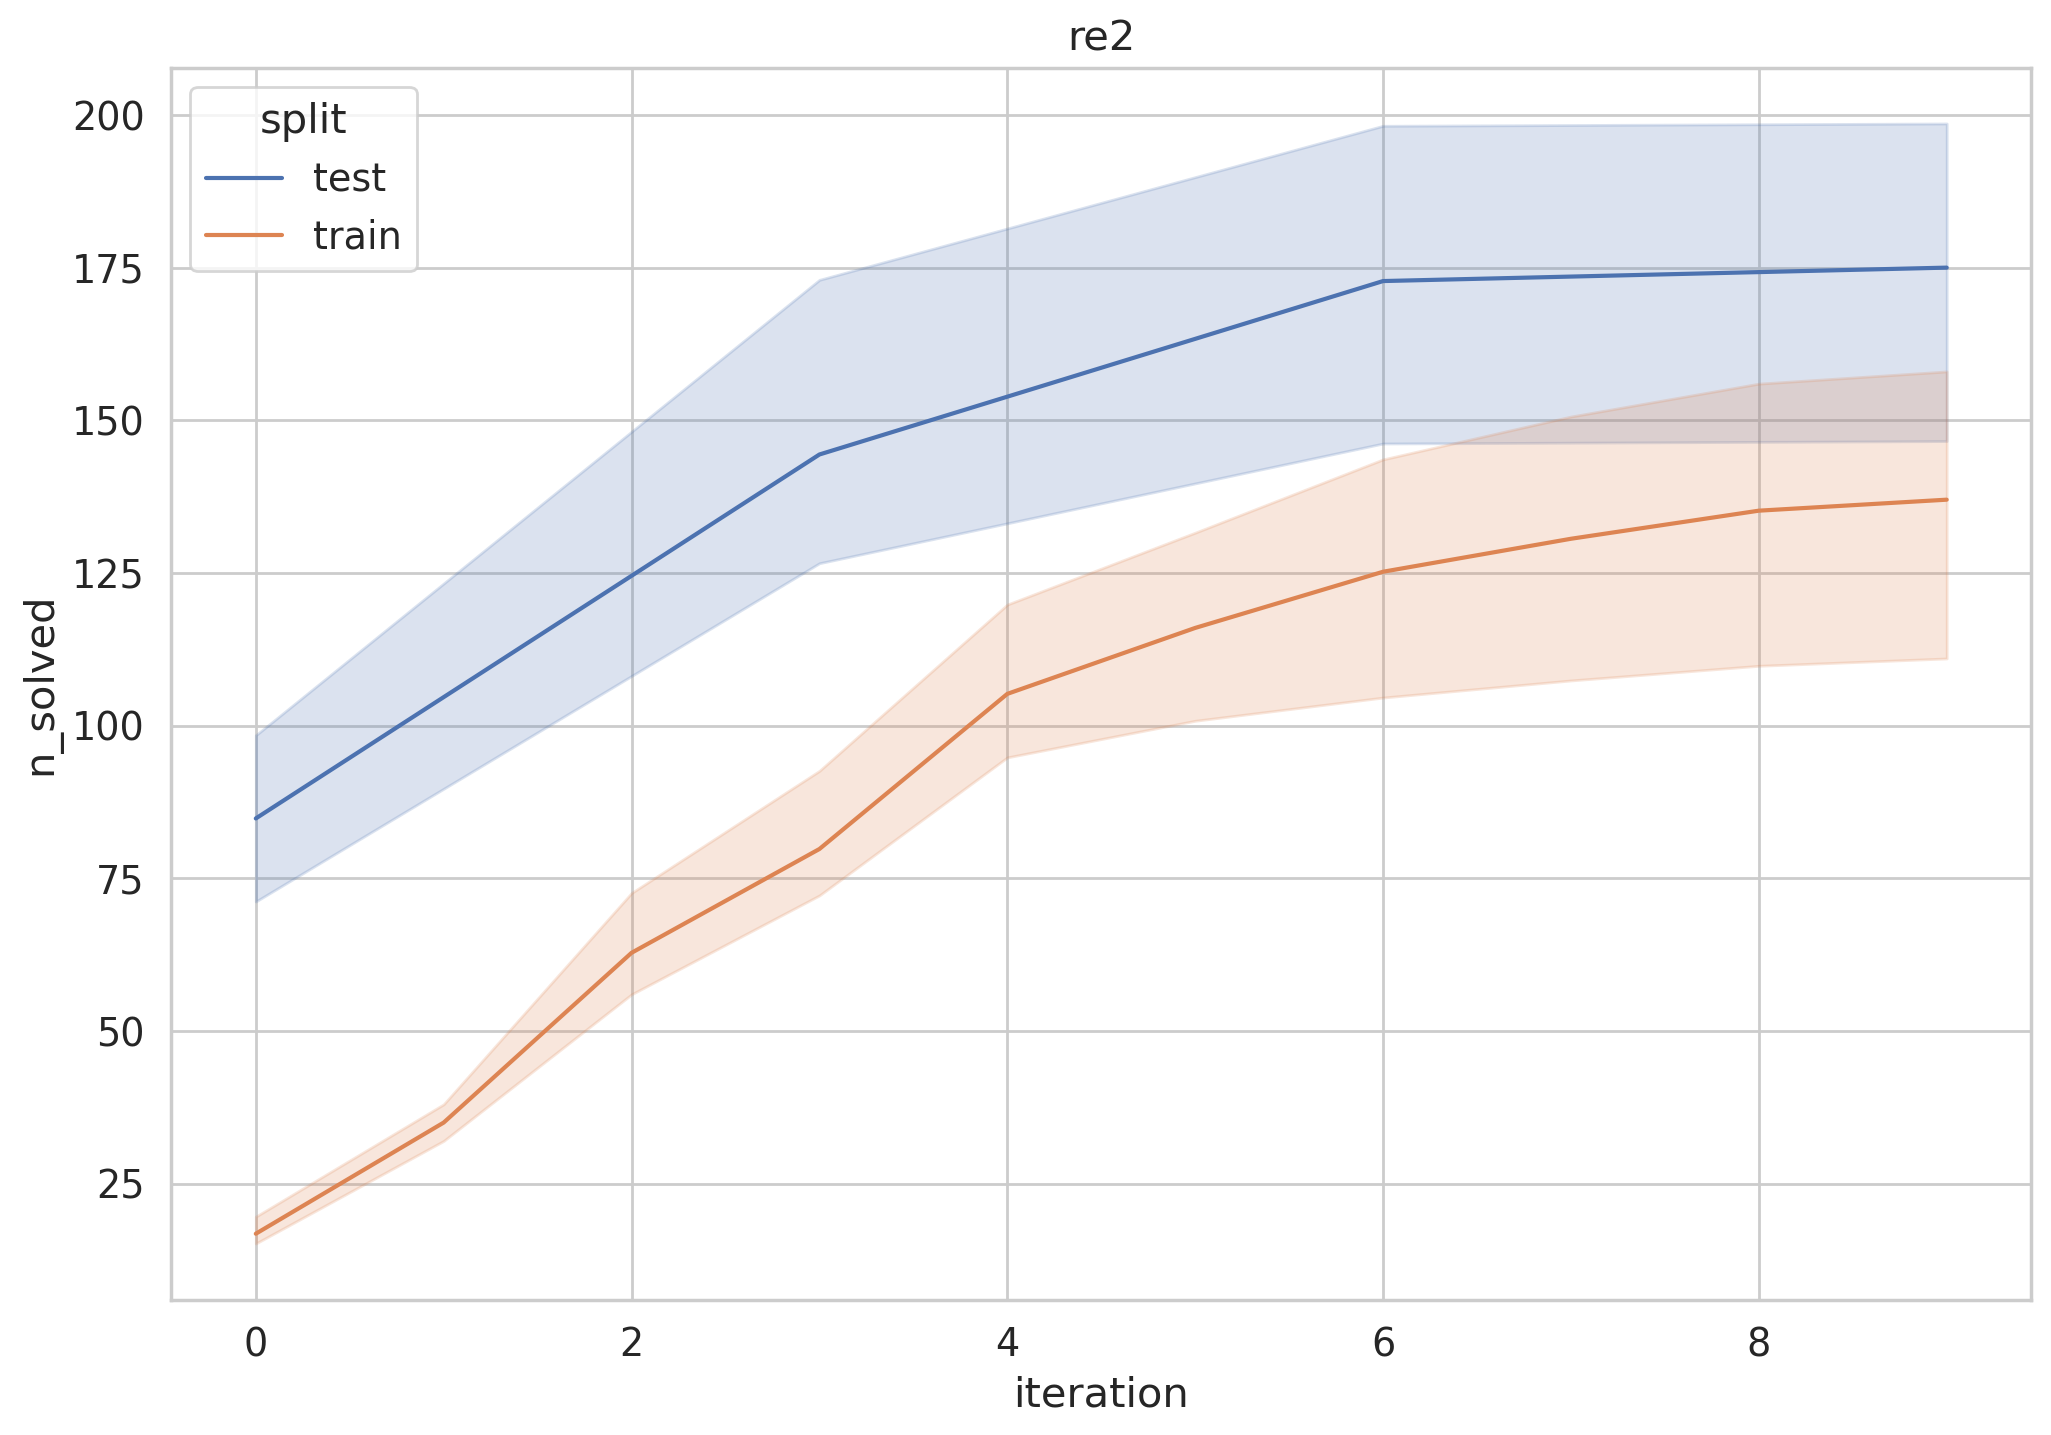

In [13]:
sns.lineplot(
    data=df_results, 
    x="iteration", 
    y="n_solved", 
    hue="split", 
    markers=True,
)
plt.title(f"{DOMAIN}")

### Tasks solved vs. search time

In [14]:
df_search_time = analyzer.get_search_time_results_for_domain(DOMAIN)
df_search_time

Using enumeration_timeout: 1000


,time,n_solved,experiment_type,seed,iteration,split
0,0,0,baseline_dreamcoder,111,0,test
1,1,0,baseline_dreamcoder,111,0,test
2,2,0,baseline_dreamcoder,111,0,test
3,3,0,baseline_dreamcoder,111,0,test
4,4,0,baseline_dreamcoder,111,0,test
...,...,...,...,...,...,...
70065,996,160,gpt_generation,222,9,train
70066,997,160,gpt_generation,222,9,train
70067,998,160,gpt_generation,222,9,train
70068,999,160,gpt_generation,222,9,train


In [15]:
df_search_time.query("experiment_type == 'gpt_generation'").seed.unique()

array([111, 222])

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "train"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (train)")

Text(0.5, 0.98, 're2 (train)')

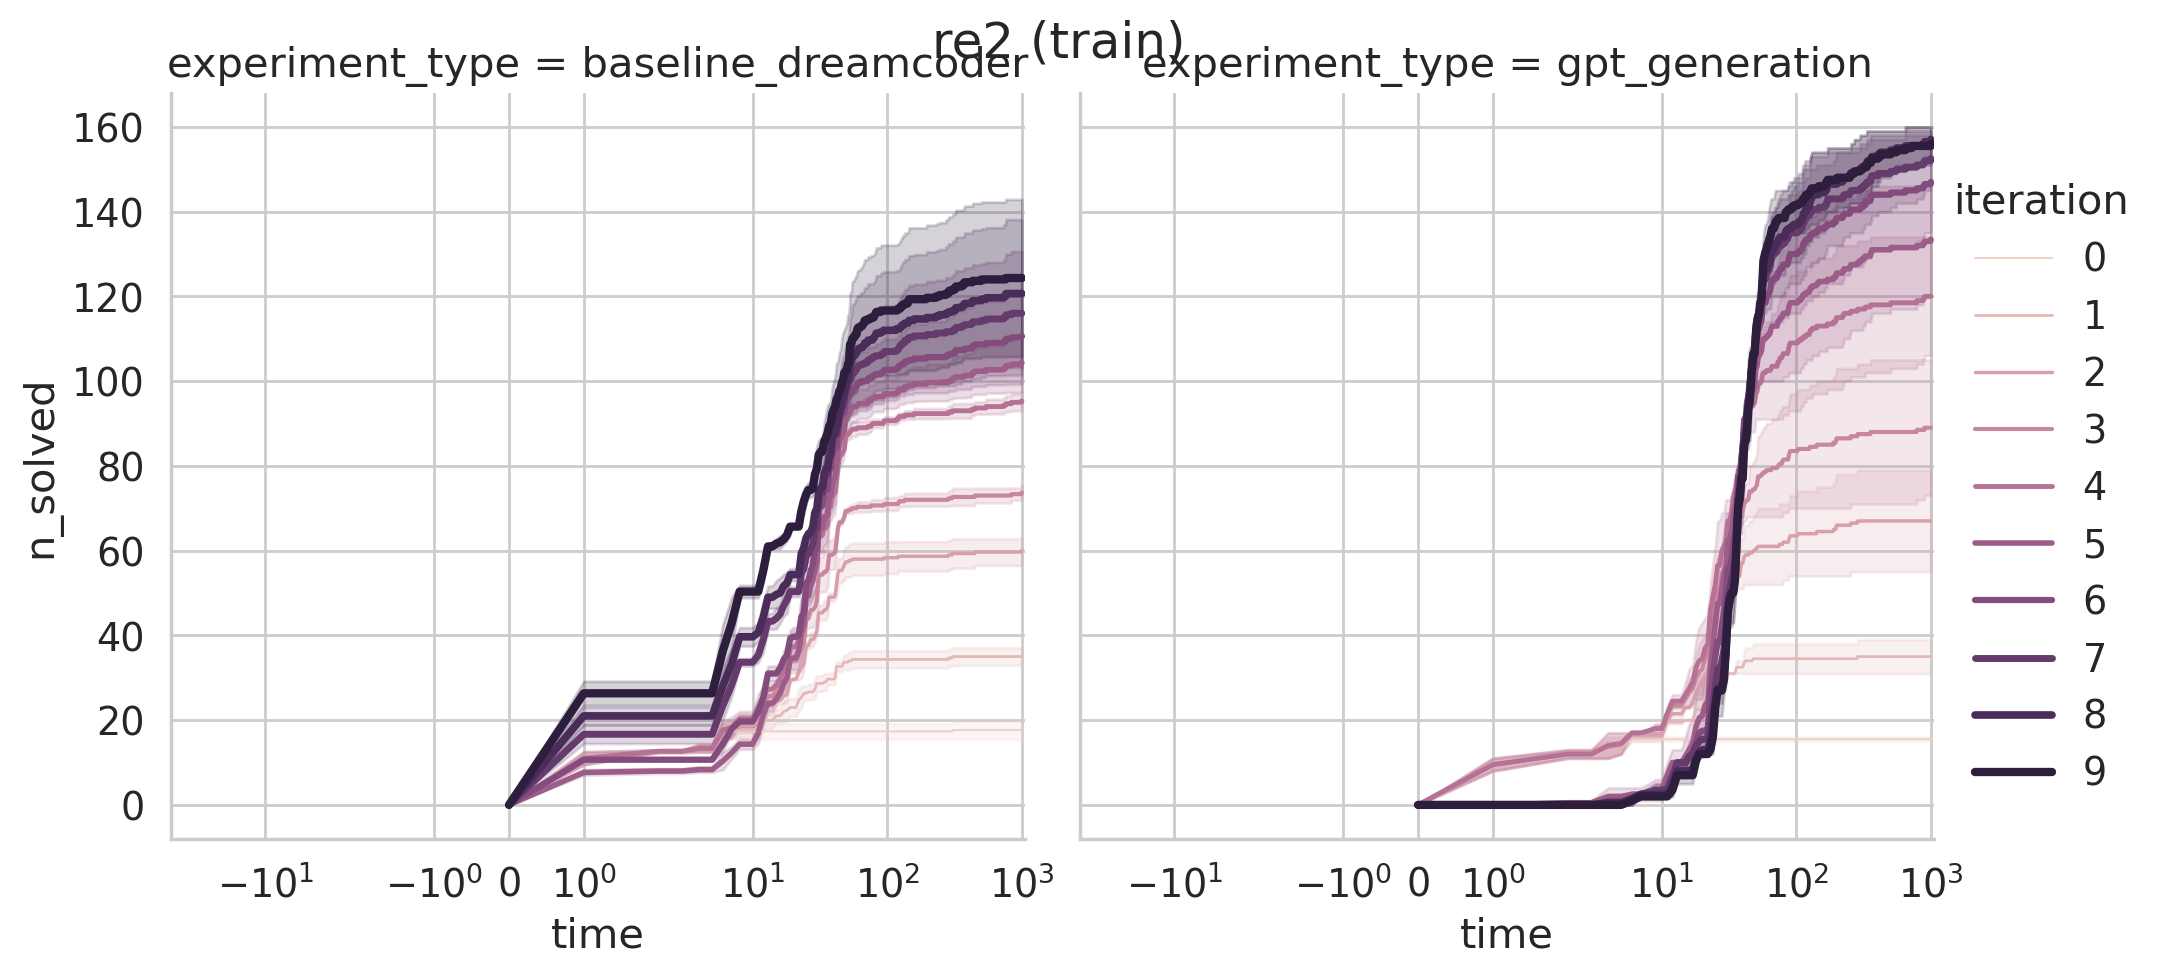

In [20]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "train"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (train)")

In [ ]:
g = sns.lineplot(
    data=df_search_time[df_search_time.split == "test"],
    x="time",
    y="n_solved",
    # hue="seed",
    hue="iteration",
    size="iteration",
    legend="full",
    errorbar="se",
)
g.set(xscale='symlog')
plt.title(f"{DOMAIN} (test)")

Text(0.5, 0.98, 're2 (test)')

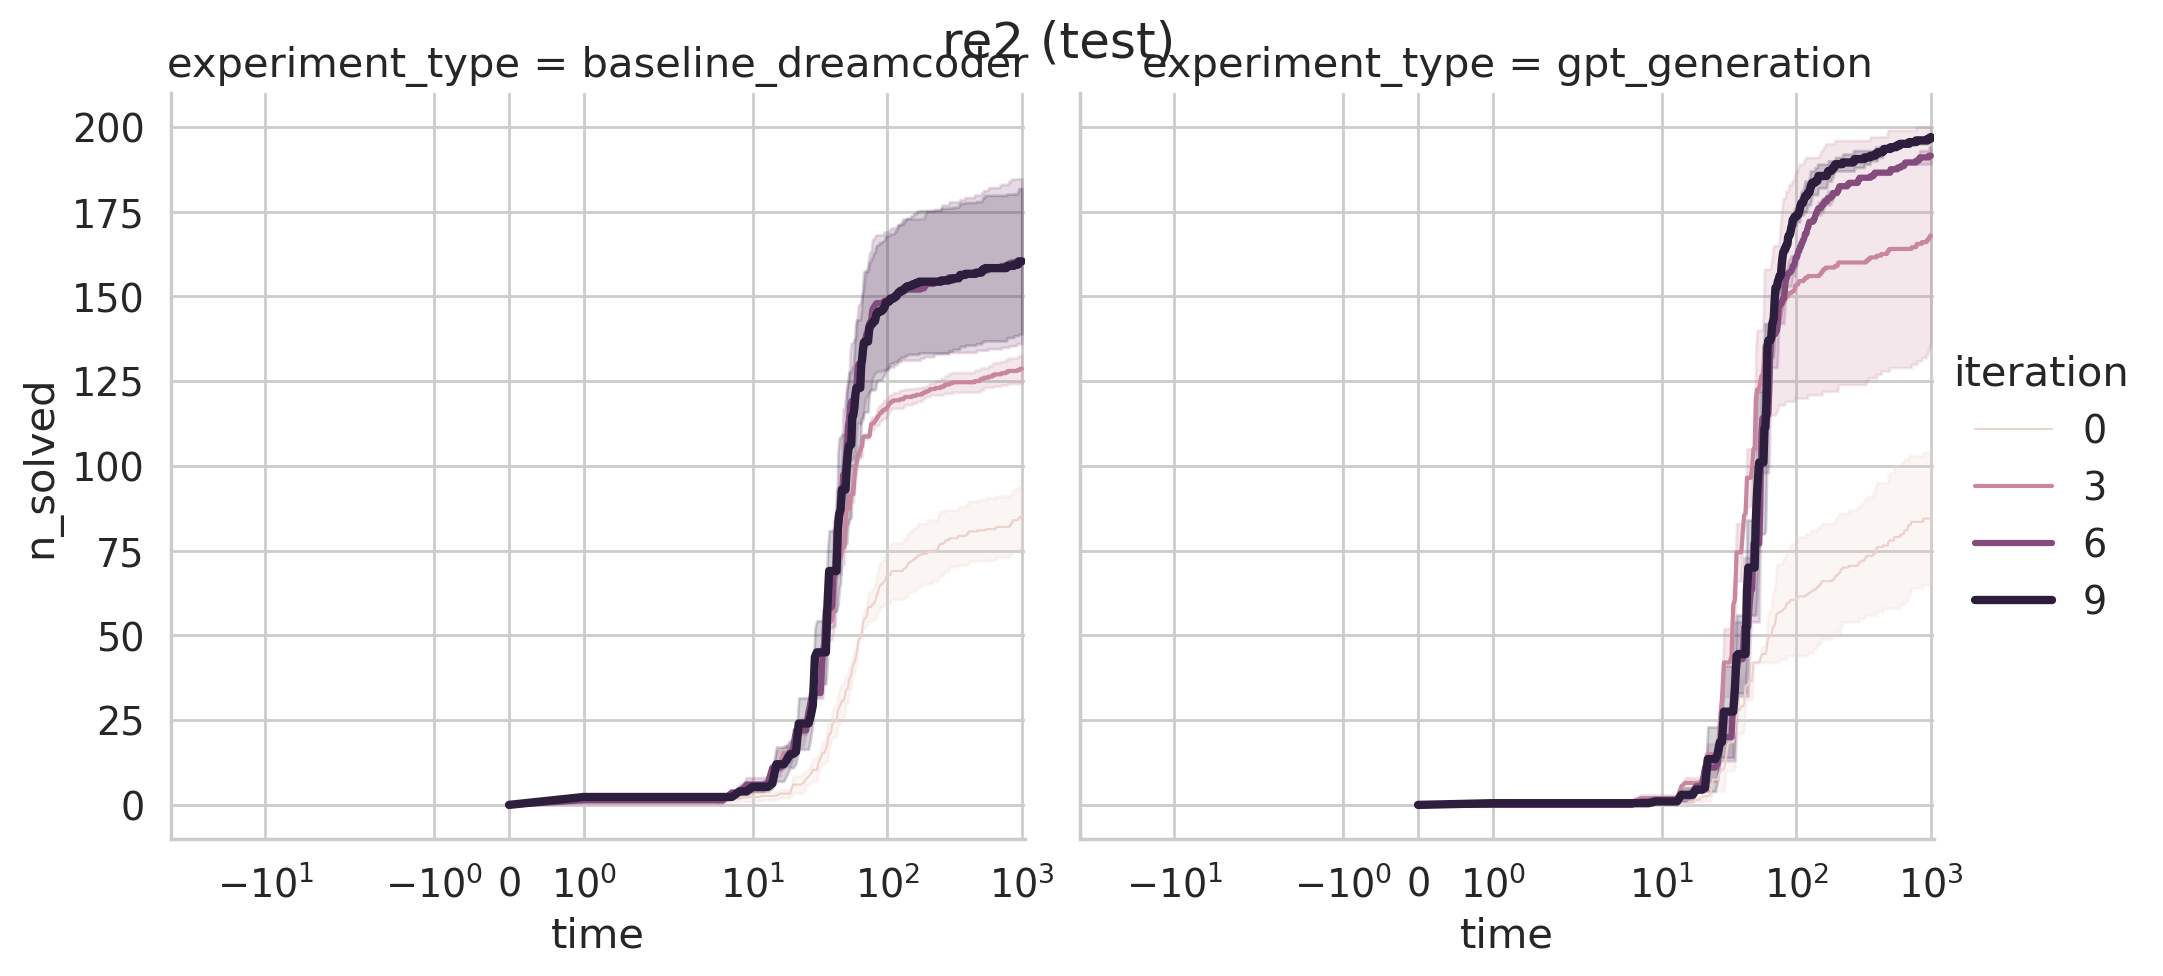

In [19]:
g = sns.relplot(
    data=df_search_time[df_search_time.split == "test"],
    col="experiment_type",
    x="time",
    y="n_solved",
    hue="iteration",
    size="iteration",
    legend="full",
    kind="line",
    errorbar="se",
)
g.set(xscale='symlog')
plt.suptitle(f"{DOMAIN} (test)")

# Analysis 2: Library abstractions

In [21]:
df_asbtractions = analyzer.get_abstractions_for_domain(DOMAIN)
df_asbtractions.to_csv(f"{DOMAIN}_abstractions.csv", index=False)
df_asbtractions

,name,arity,utility,compression_ratio,cumulative_compression_ratio,body,dreamcoder,experiment_type,random_seed,iteration,batch_size
0,fn_0,2,2020,1.196021,1.196021,(_rflatten (cons #1 (cdr (_rsplit _rempty #0)))),#(lambda (lambda (_rflatten (cons $0 (cdr (_rs...,baseline_dreamcoder,111,0,96
1,fn_1,2,1212,1.133289,1.355438,(_rflatten (_rappend #1 (_rrevcdr (_rsplit _re...,#(lambda (lambda (_rflatten (_rappend $0 (_rre...,baseline_dreamcoder,111,0,96
2,fn_2,2,909,1.111070,1.505987,(_rflatten (map #1 (_rsplit _rempty #0))),#(lambda (lambda (_rflatten (map $0 (_rsplit _...,baseline_dreamcoder,111,0,96
3,fn_3,2,404,1.051928,1.584190,(_rflatten (cons #1 (cons _a (cdr #0)))),#(lambda (lambda (_rflatten (cons $0 (cons _a ...,baseline_dreamcoder,111,0,96
4,fn_4,1,505,1.069416,1.694158,(_rsplit _rdot #0),#(lambda (_rsplit _rdot $0)),baseline_dreamcoder,111,0,96
...,...,...,...,...,...,...,...,...,...,...,...
493,fn_5,2,3535,1.078111,1.917646,(_rflatten (_rappend (_rconcat #1 _rempty) (_r...,#(lambda (lambda (_rflatten (_rappend (_rconca...,gpt_generation,222,9,96
494,fn_6,3,2430,1.056741,2.026456,(_rflatten (map (lam (_rconcat #2 #1)) (_rspli...,#(lambda (lambda (lambda (_rflatten (map (lamb...,gpt_generation,222,9,96
495,fn_7,3,1414,1.034145,2.095649,(_rflatten (cons #2 (_rsplit #1 #0))),#(lambda (lambda (lambda (_rflatten (cons $0 (...,gpt_generation,222,9,96
496,fn_8,2,1012,1.025050,2.148144,(_rflatten (map (lam (_rconcat $0 #1)) (_rspli...,#(lambda (lambda (_rflatten (map (lambda (_rco...,gpt_generation,222,9,96


In [ ]:
with pd.option_context('display.max_colwidth', None, 'display.max_rows', None):
    display(df_asbtractions.sort_values(["experiment_type", "name", "iteration"])[["experiment_type", "name", "iteration", "arity", "compression_ratio", "dreamcoder"]])

<AxesSubplot:xlabel='name', ylabel='compression_ratio'>

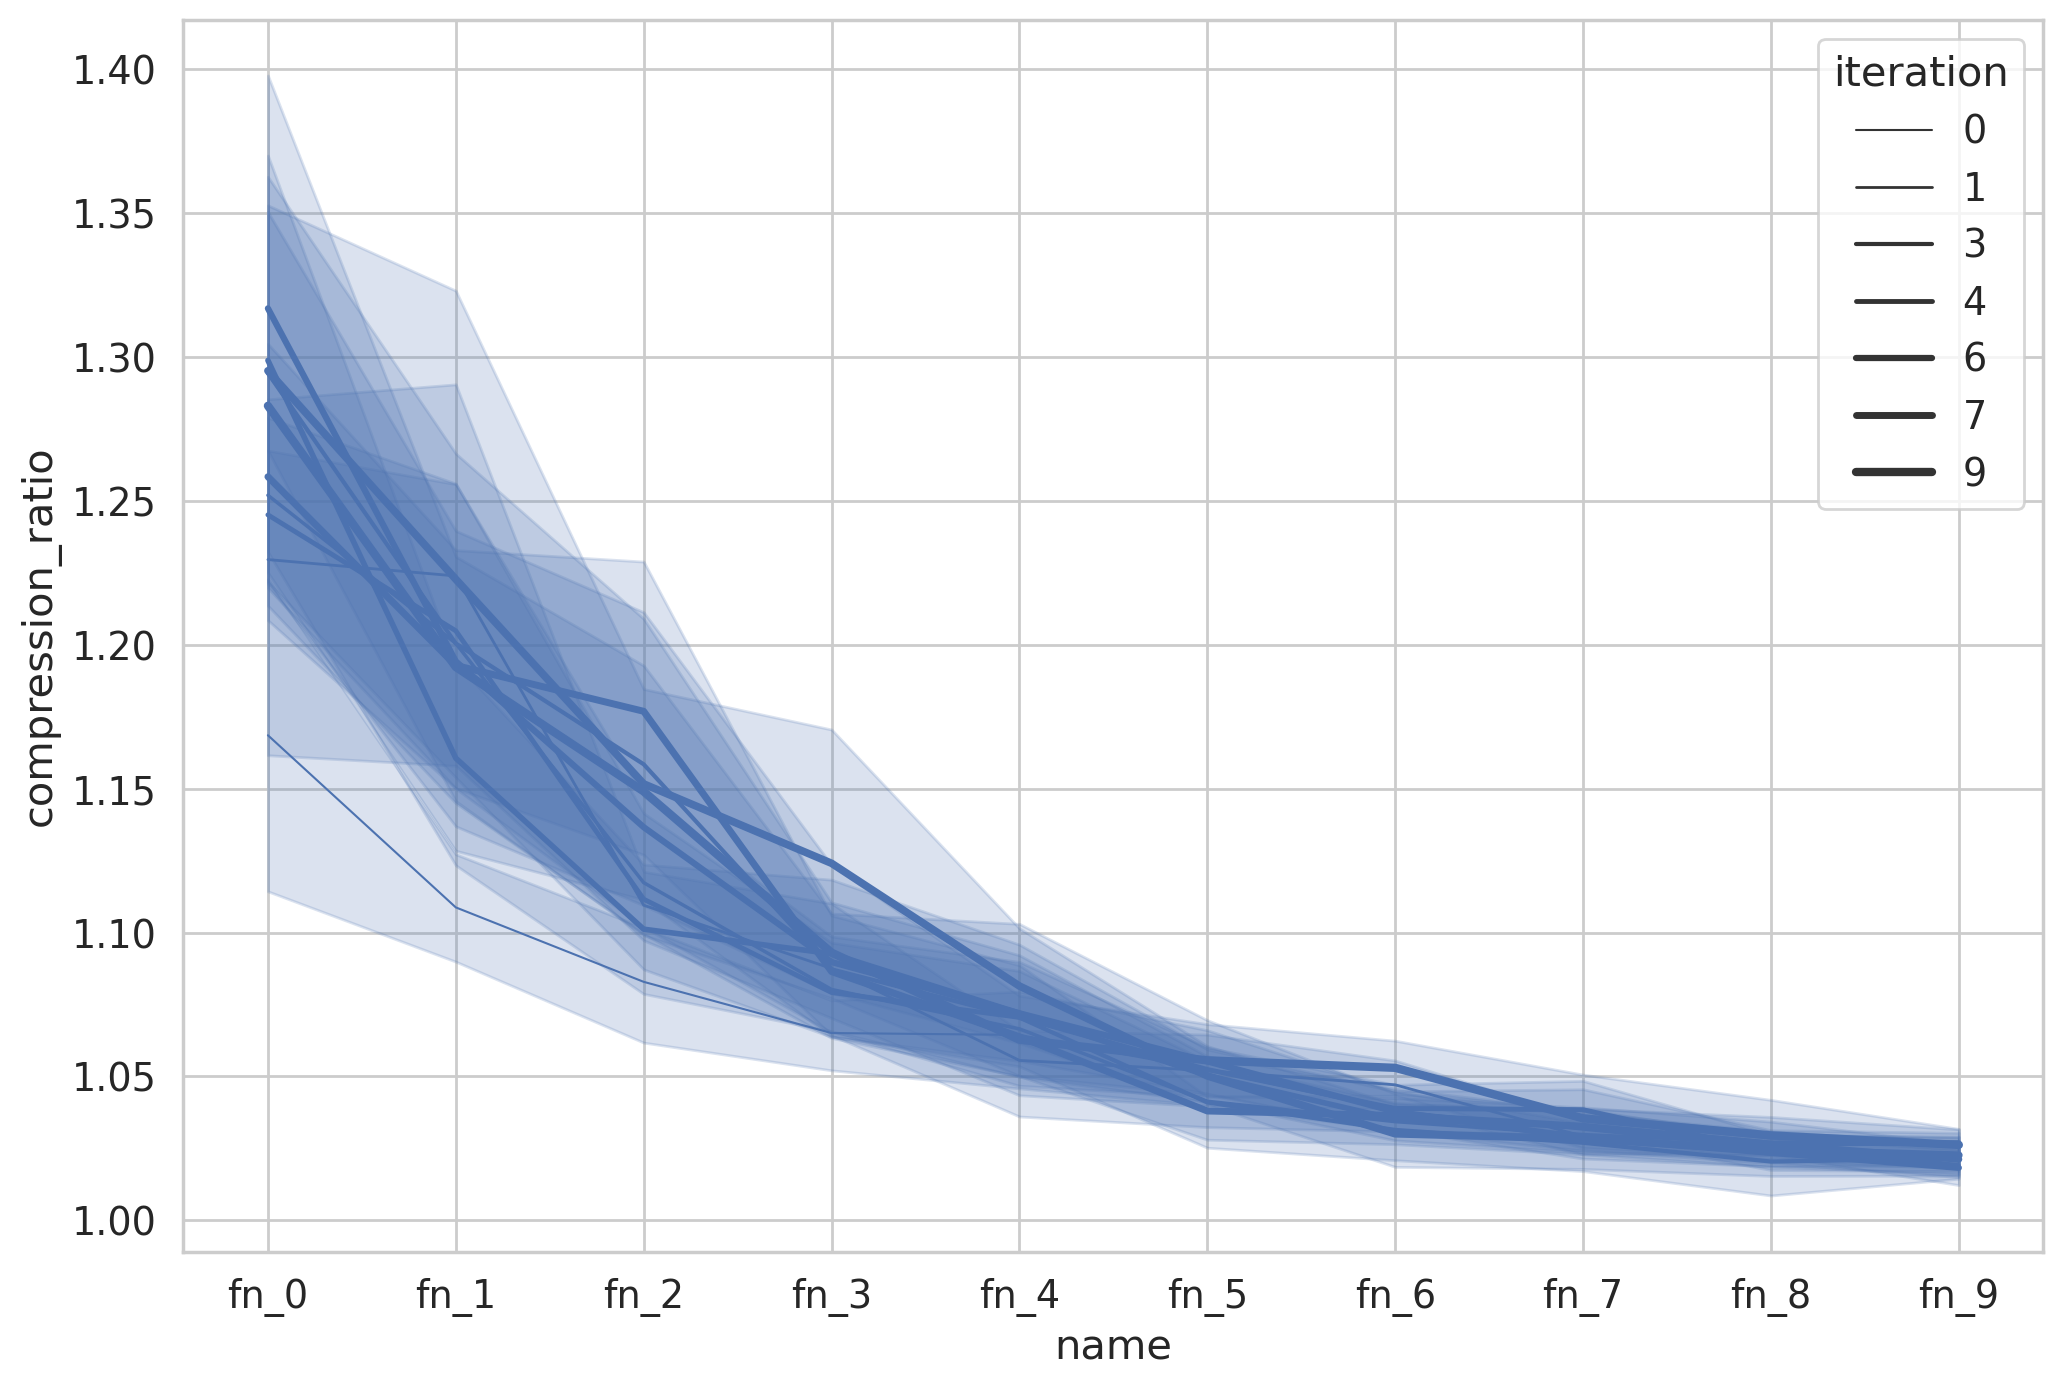

In [25]:
sns.lineplot(data=df_asbtractions, x="name", y="compression_ratio", size="iteration")

Text(0.5, 1.0, 're2 compressivity of library')

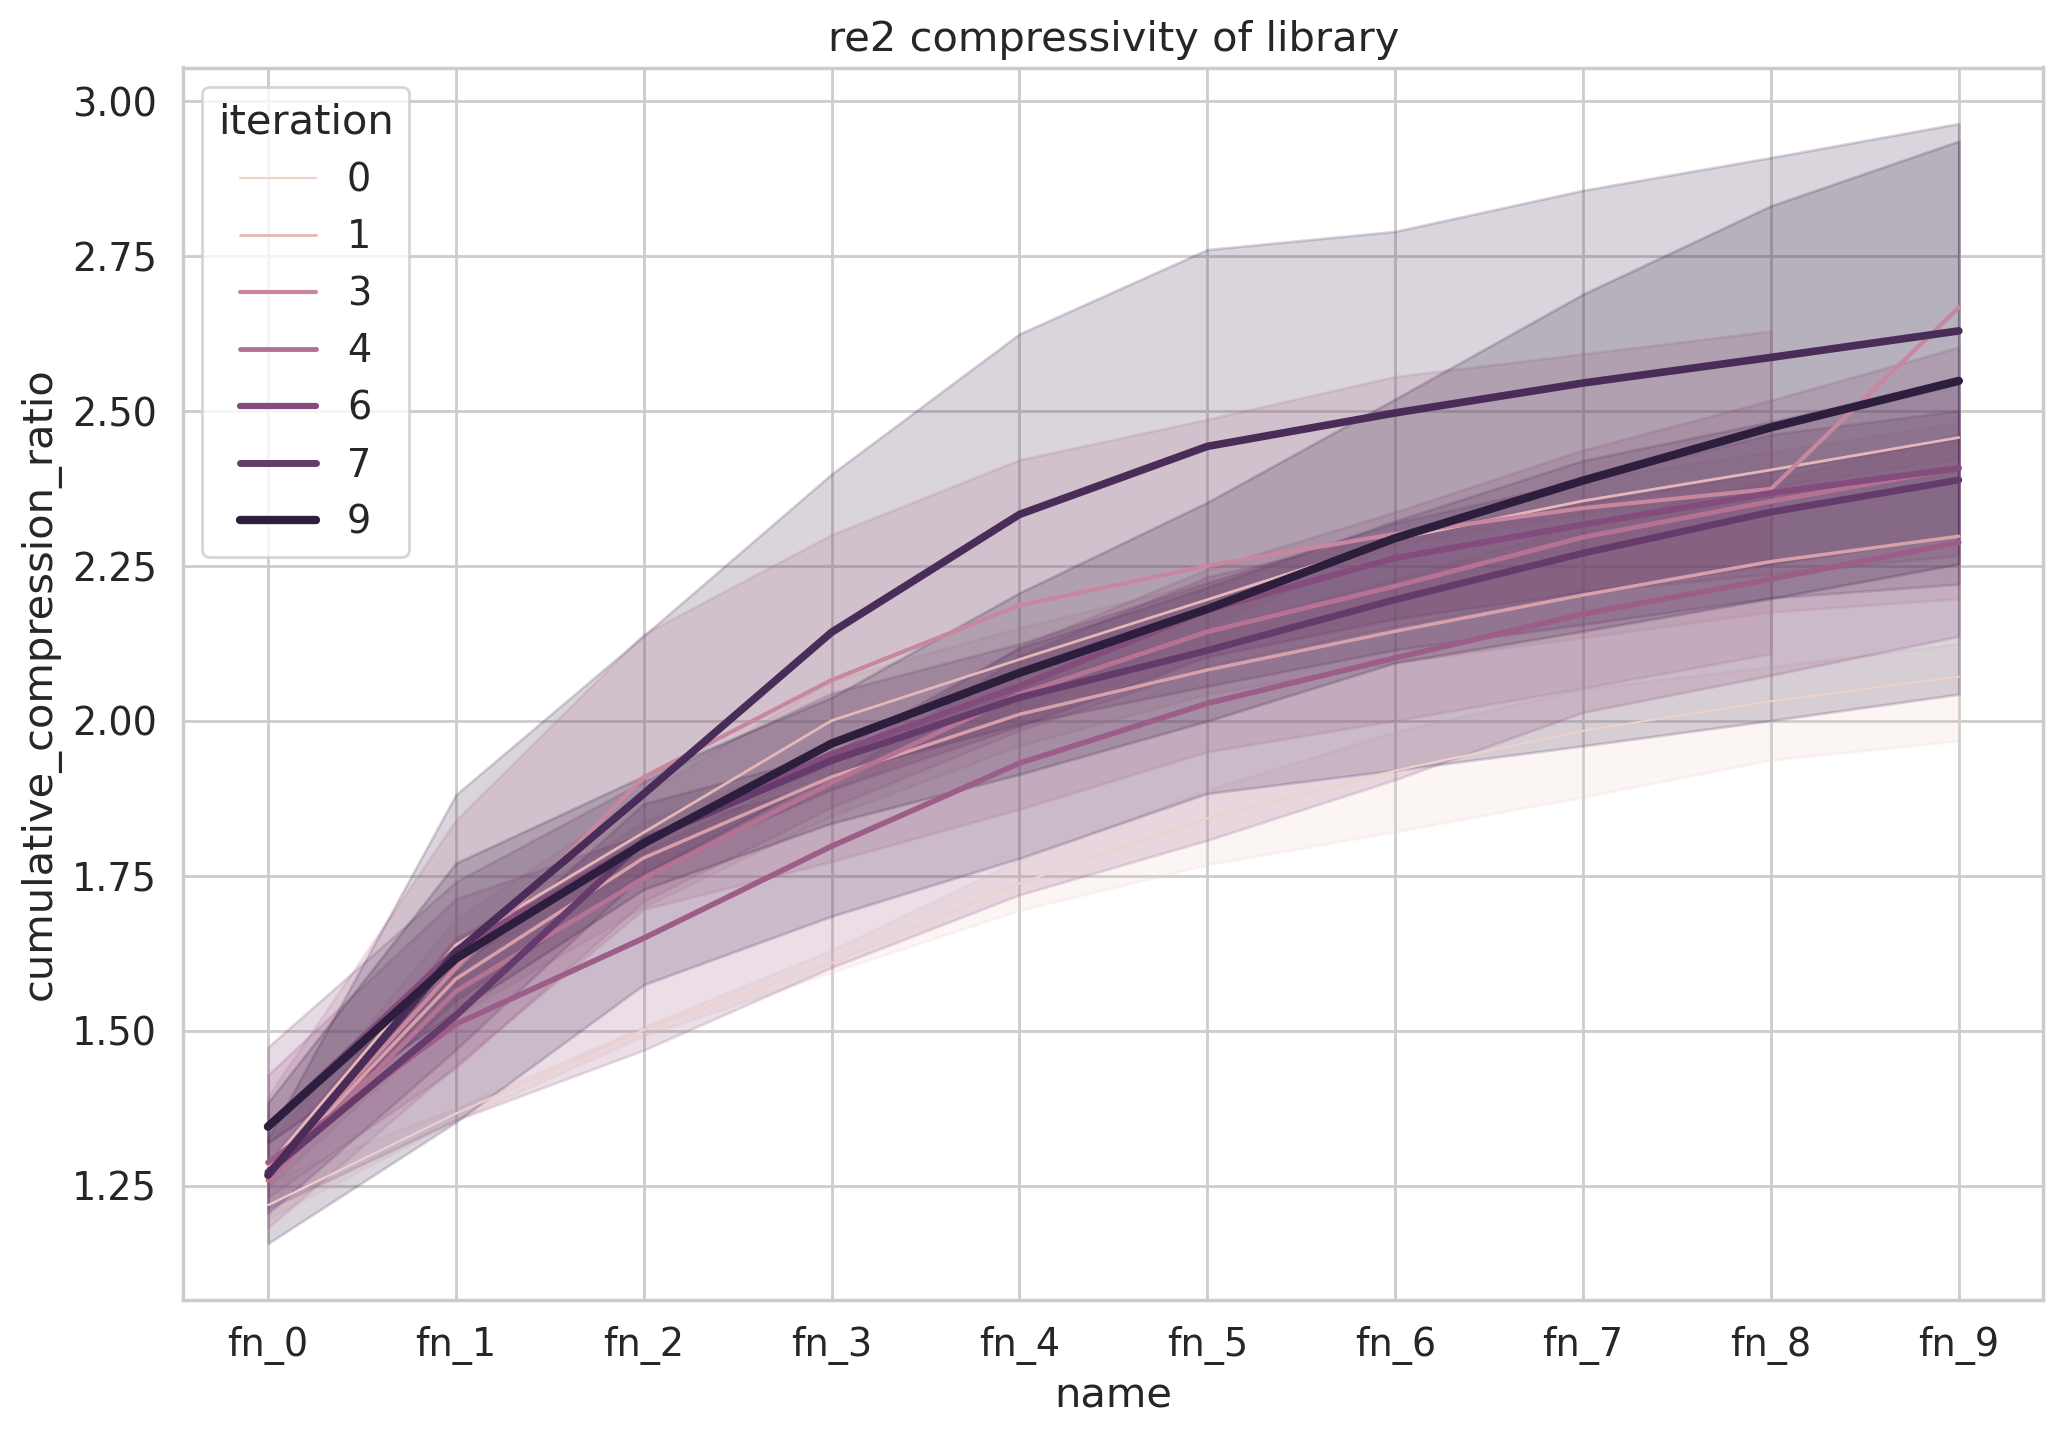

In [50]:
sns.lineplot(data=df_asbtractions, x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.title(f"{DOMAIN} compressivity of library")

Text(0.5, 0.98, 're2 compressivity of library')

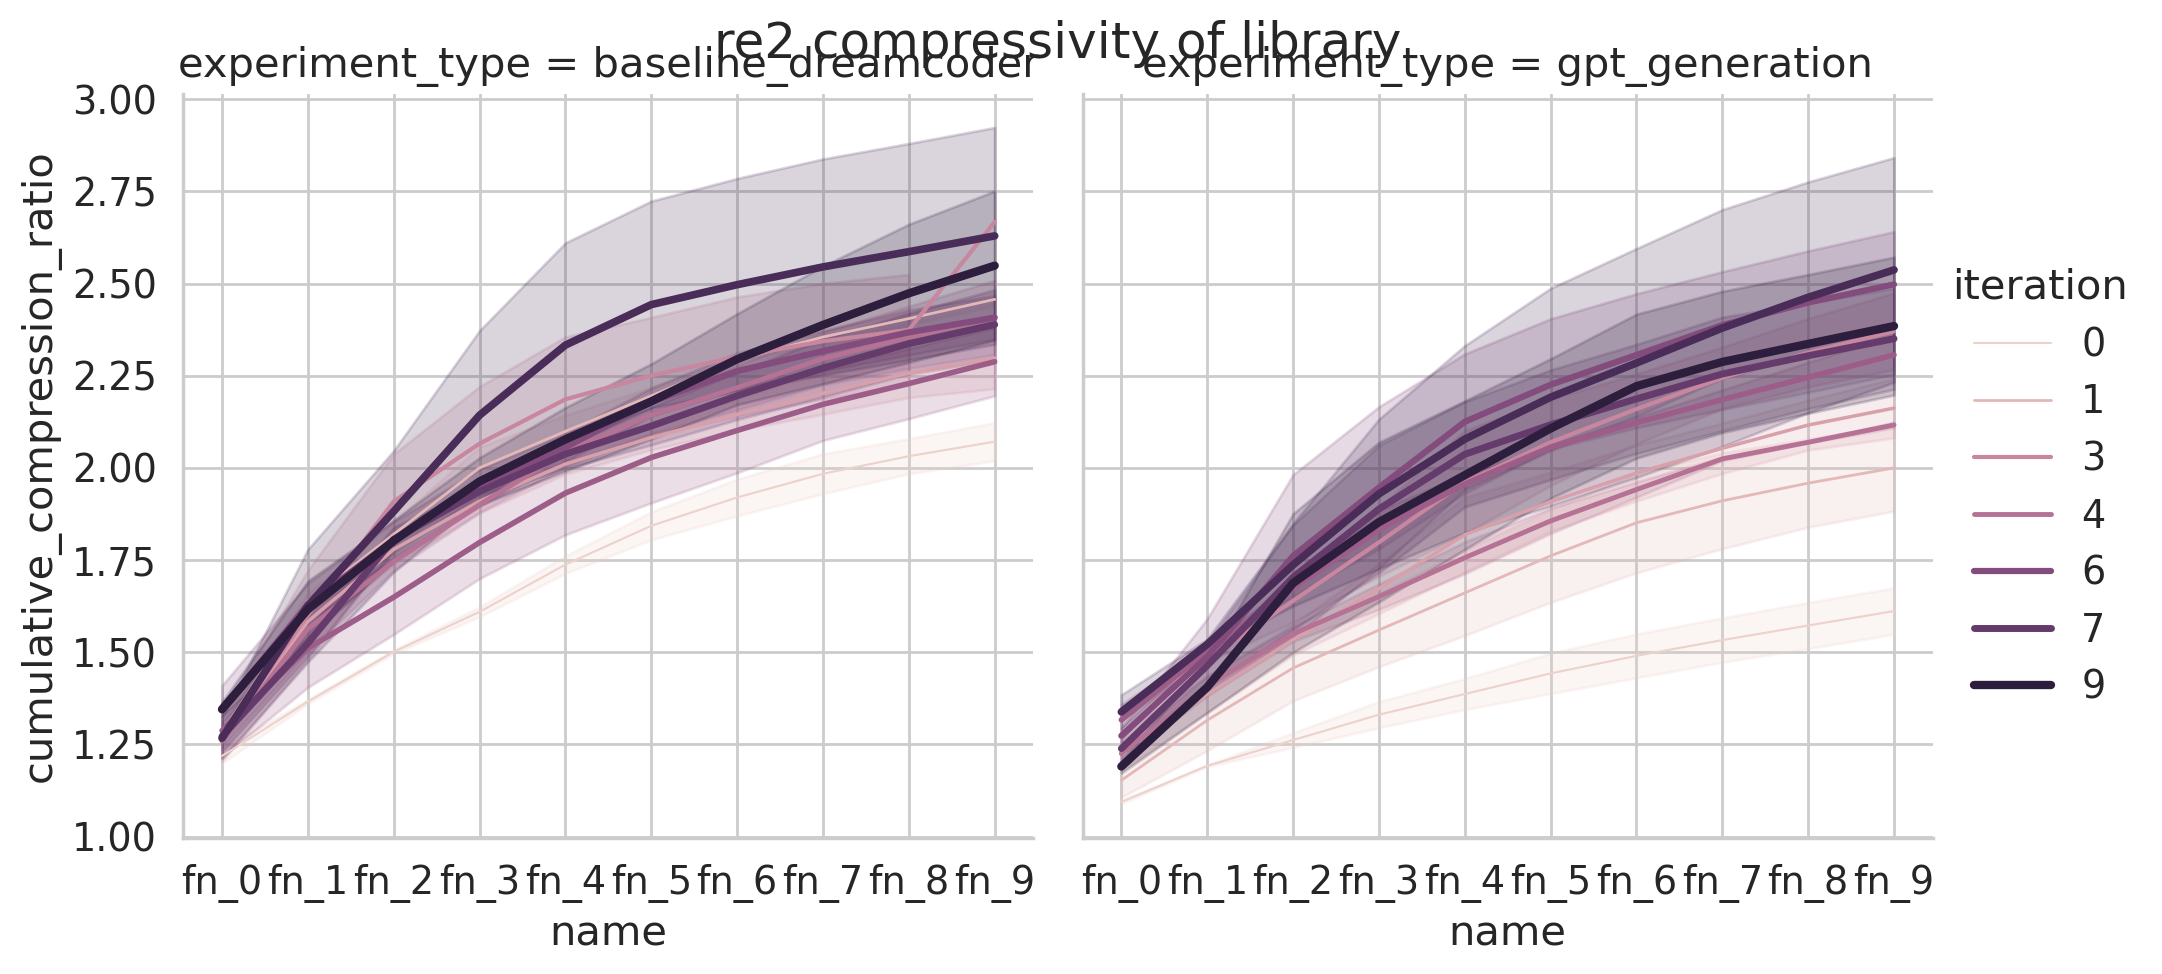

In [27]:
sns.relplot(data=df_asbtractions, kind="line", errorbar="se", col="experiment_type", x="name", y="cumulative_compression_ratio", size="iteration", hue="iteration")
plt.suptitle(f"{DOMAIN} compressivity of library")

# Analysis 3: Solved programs

In [28]:
df = analyzer.get_synthesis_results_for_domain(DOMAIN)
df.to_csv(f"{DOMAIN}_search_results.csv")

# re2-specific analysis

In [33]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def task_order(keys):
    return [int(re.split(r'(\d+)', k[len("re2_test_"):])[1]) for k in keys]

def alpha_order(keys):
    return [re.split(r'(\d+)', k[len("re2_test_"):])[-1] for k in keys]

In [43]:
df_solved_i3 = df[~pd.isnull(df.best_search_time)].query("split == 'test'").query("iteration == 6").query("seed == 222")

In [44]:
df_solved_sorted = df_solved_i3[["task", "experiment_type", "best_search_time"]].pivot(index="task", columns=["experiment_type"]).sort_index(key=alpha_order)
df_solved_sorted = df_solved_sorted.reset_index(level=0)

In [45]:
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(df_solved_sorted)

task  \
experiment_type                                                                                    
0                                  re2_test_73_if_the_word_ends_with_any_letter_add_a_after_that   
1                                 re2_test_100_if_the_word_ends_with_any_letter_add_m_after_that   
2                                re2_test_176_if_the_word_ends_with_any_letter_add_m_before_that   
3                                re2_test_493_if_the_word_ends_with_any_letter_add_n_before_that   
4                                re2_test_230_if_the_word_ends_with_any_letter_add_p_before_that   
5                      re2_test_365_if_the_word_ends_with_any_letter_any_letter_add_h_after_that   
6                      re2_test_290_if_the_word_ends_with_any_letter_any_letter_add_x_after_that   
7                       re2_test_496_if_the_word_ends_with_any_letter_consonant_add_h_after_that   
8                    re2_test_354_if_the_word_ends_with_any_letter_consonant_replace_that_with_t   
9                               re2_test_13_if_the_word_ends_with_any_letter_replace_that_with_a   
10                           re2_test_389_if_the_word_ends_with_any_letter_replace_that_with_d_m   
11                             re2_test_270_if_the_word_ends_with_any_letter_replace_that_with_e   
12                           re2_test_109_if_the_word_ends_with_any_letter_replace_that_with_i_u   
13                           re2_test_361_if_the_word_ends_with_any_letter_replace_that_with_i_x   
14                             re2_test_304_if_the_word_ends_with_any_letter_replace_that_with_j   
15                            re2_test_14_if_the_word_ends_with_any_letter_replace_that_with_l_k   
16                             re2_test_124_if_the_word_ends_with_any_letter_replace_that_with_m   
17                           re2_test_218_if_the_word_ends_with_any_letter_replace_that_with_m_r   
18                           re2_test_449_if_the_word_ends_with_any_letter_replace_that_with_n_l   
19                           re2_test_459_if_the_word_ends_with_any_letter_replace_that_with_o_o   
20                           re2_test_178_if_the_word_ends_with_any_letter_replace_that_with_p_q   
21                           re2_test_371_if_the_word_ends_with_any_letter_replace_that_with_r_i   
22                           re2_test_204_if_the_word_ends_with_any_letter_replace_that_with_r_r   
23                            re2_test_30_if_the_word_ends_with_any_letter_replace_that_with_v_n   
24                             re2_test_407_if_the_word_ends_with_any_letter_replace_that_with_w   
25                           re2_test_474_if_the_word_ends_with_any_letter_replace_that_with_y_r   
26                                 re2_test_139_if_the_word_ends_with_consonant_add_l_after_that   
27                                re2_test_340_if_the_word_ends_with_consonant_add_m_before_that   
28                                 re2_test_21_if_the_word_ends_with_consonant_add_r_before_that   
29                                re2_test_410_if_the_word_ends_with_consonant_add_v_before_that   
30                                 re2_test_200_if_the_word_ends_with_consonant_add_w_after_that   
31                                 re2_test_275_if_the_word_ends_with_consonant_add_x_after_that   
32                   re2_test_430_if_the_word_ends_with_consonant_any_letter_replace_that_with_w   
33                            re2_test_385_if_the_word_ends_with_consonant_replace_that_with_a_m   
34                            re2_test_313_if_the_word_ends_with_consonant_replace_that_with_a_x   
35                             re2_test_74_if_the_word_ends_with_consonant_replace_that_with_c_v   
36                            re2_test_316_if_the_word_ends_with_consonant_replace_that_with_e_s   
37                            re2_test_426_if_the_word_ends_with_consonant_replace_that_with_g_e   
38                            re2_test_123_if_the_word_ends_with_consonant_replace_that_with